In [1]:
from IPython.display import Image

# 9. 웹 애플리케이션에 머신 러닝 모델 내장
* 머신 러닝 모델의 현재 훈련 상태 저장
* SQLite 데이터베이스를 사용하여 데이터 저장
* Flask 웹 프레임워크를 사용하여 웹 애플리케이션 개발
* 공개 웹 서버에 머신러닝 애플리케이션 배포

# 9.1 학습된 사이킷런 추정기 저장
* 학습된 모델 재사용 - pickle 모듈 : https://docs.python.org/3.7/library/pickle.html
    * 파이썬 객체의 구졸르 압축된 바이트코드로 직렬화하고 복원할 수 있다.
    
    

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path='/content/drive/MyDrive/머신러닝 교과서 with 파이썬, 사이킷런, 텐서플로/data/movie_data.csv')

In [4]:
!pip install pyprind

In [5]:
import pyprind
pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32


In [6]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('정확도: %.3f' % clf.score(X_test, y_test))

정확도: 0.868


In [7]:
clf = clf.partial_fit(X_test, y_test)

로지스틱 회귀 모델을 훈련한 후에 분류기, 불용어, 포터 어간 추출기, HashingVectorizer를 로컬 디스크에 직렬화된 객체로 저장.

* pickle
    * dump 메서드를 사용하여 훈련된 로지스틱 회귀 모델뿐만 아니라 NLTK 라이브러리의 불용어도 직렬화하여 저장.
        * 이후 NLTK 라이브러리를 설치하지 않기 위해
    * dump 메서드 매개변수
        * 첫 번째 대상 객체를 받는다.
        * 두 번째 파이썬 객체가 저장될 파일 객체를 받는다.
        * pickle 모듈을 위해 open 함수에서 wb 매개변수를 사용하여 이진 모드로 파일을 엽니다.
        * protocol=4로 지정하여 파이썬 3.4 버전과 그 이상 버전에서 사용할 수 있는 가장 효율적이고 최신의 pickle 프로토콜을 사용.

In [8]:
import pickle
import os

dest = os.path.join('movieclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

HashingVectorizer는 학습 과정이 없기 때문에 pickle로 직렬화할 필요가 없다. 그 대신 현재 사용하고 있는 파이썬 세션에서 HashingVectorizer 객체를 임포트할 수 있도록 파이썬 스크립트를 만든다.

In [9]:
%%writefile movieclassifier/vectorizer.py
from sklearn.feature_extraction.text import HashingVectorizer
import re
import os
import pickle

cur_dir = os.path.dirname(__file__)
stop = pickle.load(open(
                os.path.join(cur_dir, 
                'pkl_objects', 
                'stopwords.pkl'), 'rb'))

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) \
                   + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

Overwriting movieclassifier/vectorizer.py


In [10]:
# 현재 디렉토리를 movieclassifier로 변경
os.chdir('movieclassifier')

In [11]:
# vectorizer를 임포트한 후 복원한 분류기 객체를 사용하여 문서 샘플을 전처리하고 감성 레이블을 예측
from vectorizer import vect

clf = pickle.load(open(os.path.join('pkl_objects', 'classifier.pkl'), 'rb'))

In [12]:
import numpy as np
label = {0:'음성', 1:'양성'}
example = ["I love this movie. It's amazing."]
X = vect.transform(example)
print('예측: %s\n확률: %.2f%%' %\
      (label[clf.predict(X)[0]], 
       np.max(clf.predict_proba(X))*100))

예측: 양성
확률: 95.55%


# 9.2 데이터를 저장하기 위해 SQLite 데이터베이스 설정


In [13]:
os.getcwd() # 현재 위치 확인

'/content/movieclassifier'

In [14]:
import sqlite3

# sqlite 라이브러리의 connect 메서드를 호출하여 SQLite 데이터베이스에 연결
conn = sqlite3.connect('reviews.sqlite') # movieclassifier 디렉터리에 reviews.sqlite가 없다면 새로운 데이터베이스 파일을 만든다
c = conn.cursor() # 데이터베이스 커서 - SQL 문법으로 데이터베이스 레코드 조작 가능

c.execute('DROP TABLE IF EXISTS review_db')
c.execute('CREATE TABLE review_db (review TEXT, sentiment INTEGER, date TEXT)') # 테이블 생성

example1 = 'I love this movie'
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example1, 1))

example2 = 'I disliked this movie'
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example2, 0))

conn.commit() # 데이터베이스 변경사항 저장
conn.close() # 데이터베이스 연결 끊음

In [15]:
conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()

c.execute("SELECT * FROM review_db WHERE date BETWEEN '2017-01-01 10:10:10' AND DATETIME('now')")
results = c.fetchall()

conn.close()

print(results)

[('I love this movie', 1, '2022-01-23 16:18:25'), ('I disliked this movie', 0, '2022-01-23 16:18:25')]


In [16]:
# SQLite 전용 데이터베이스 브라우저 : https://sqlitebrowser.org/
Image(url='https://git.io/Jts3V', width=700) 

# 9.3 플라스크 웹 애플리케이션 개발

### 9.3.1 첫 번째 플라스크 애플리케이션

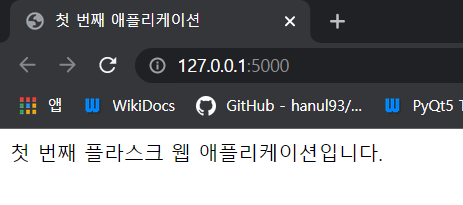

### 9.3.2 폼 검증과 화면 출력

* WTForms 라이브러를 사용하여 사용자로부터 데이터 수집

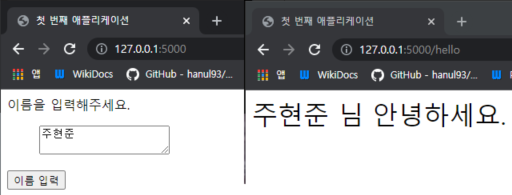